<a href="https://colab.research.google.com/github/Nikita-devel/DS_Hw5/blob/main/DS_Hm5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from pathlib import Path
from time import time

def gen_saved_name(key):
    return SAVED_DATAFRAME_BASE.joinpath(f"data-{key}.father")

def load_or_save_dataset(key, class_list, skip_load=False):
    filename = gen_saved_name(key)
    if not skip_load and filename.is_file():
        df = pd.read_feather(filename)
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        print(f"DATASET {key}. Loaded. shape: {df.shape}")
    else:
        df = pd.DataFrame()
        X = pd.DataFrame()
        y = pd.Series()
    return df, X, y

def save_dataset(key, df):
    filename = gen_saved_name(key)
    if not df.empty and not filename.is_file():
        df.to_feather(filename)

# Function to prepare dataset
def prepare_dataset(class_path, flatten=True, stat_feature=True, limit_frames=None):
    dfws = []
    for class_id, work_class_path in enumerate(class_path):
        list_files = list(sorted(work_class_path.glob('*.csv'), key=lambda path: int(path.stem.rsplit("-", 1)[1])))
        print(f"Importing class '{work_class_path.name:7}' : {class_id}. Frames: {len(list_files)}")
        for i, filename in enumerate(list_files):
            df_w = pd.read_csv(filename)
            addon_features = [df_w]
            if flatten:
                addon_features = [flatten_frame(df_w)]
            if stat_feature:
                addon_features.append(add_stat_feature_frame(df_w, addon_features[0].shape[0]))
            df_w = pd.concat(addon_features, axis=1)
            df_w['class'] = class_id
            dfws.append(df_w)
            if limit_frames and (i > limit_frames):
                break
    df = pd.concat(dfws, axis=0, ignore_index=True)
    print(df.shape)
    return df

def flatten_frame(frame):
    columns = [f"{col}_{i}" for i in range(frame.shape[0]) for col in frame.columns]
    return pd.DataFrame(frame.values.reshape(1, -1), columns=columns)

def add_stat_feature_frame(frame, rows):
    features = []
    for col_id in range(0, 3):
        col = frame.iloc[:, col_id]
        features.append(pd.DataFrame([col.mean()] * rows, columns=[f'{col.name}_mean']))

    result = pd.concat(features, axis=1)
    return result


In [3]:

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    clf = model()

    start_time_fit = time()
    clf.fit(X_train, y_train)
    end_time_fit = time()

    start_time_predict = time()
    y_test_predict = clf.predict(X_test)
    end_time_predict = time()

    fit_time = end_time_fit - start_time_fit
    predict_time = end_time_predict - start_time_predict

    report = classification_report(y_test, y_test_predict, digits=4, target_names=class_list)

    return clf, y_test_predict, report, fit_time, predict_time


In [7]:

DATASET_KEYS = ("f0s0", "f0s1", "f1s0", "f1s1")
SAVED_DATAFRAME_BASE = Path("/content/")
URL = "https://drive.usercontent.google.com/download?id=1nzrtQpfaHL0OgJ_eXzA7VuEj7XotrSWO&export=download&authuser=0"
OUTPUT = Path("/content/homework")
CSV_DATA_PATH  = Path("/content/data")

if not OUTPUT.is_file():
  !wget -O $OUTPUT $URL

if OUTPUT.is_file() and not CSV_DATA_PATH.is_dir():
  !unzip -q -o $OUTPUT
  #!rm $OUTPUT

df_set = {}
X_set = {}
y_set = {}

if CSV_DATA_PATH.is_dir():
    class_path = list(CSV_DATA_PATH.iterdir())
    class_list = list(d.name for d in class_path)
    print(class_list)

reports = {}
skip_models = {
    "SVC_Linear": ["f0s0"]
}

SEED = 42
limit_frames = None

class_list = ["idle", "running", "walking", "stairs"]

for key in DATASET_KEYS:
    df_set[key], X_set[key], y_set[key] = load_or_save_dataset(key, class_list, skip_load=False)

for f in range(2):
    for s in range(2):
        key_set = f"f{f}s{s}"
        print(f"\nDATASET {key_set}. Where flatten={bool(f)}, stat_feature={bool(s)}")
        if df_set.get(key_set) is not None and (not df_set[key_set].empty):
            print("Already loaded, skipped")
            continue
        df_set[key_set] = prepare_dataset(class_path, flatten=f, stat_feature=s, limit_frames=limit_frames)
        save_dataset(key_set, df_set[key_set])
        X_set[key_set] = df_set[key_set].iloc[:, :-1]
        y_set[key_set] = df_set[key_set].iloc[:, -1]




['idle', 'running', 'walking', 'stairs']
DATASET f0s0. Loaded. shape: (193860, 4)
DATASET f0s1. Loaded. shape: (193860, 7)
DATASET f1s0. Loaded. shape: (6462, 91)
DATASET f1s1. Loaded. shape: (6462, 94)

DATASET f0s0. Where flatten=False, stat_feature=False
Already loaded, skipped

DATASET f0s1. Where flatten=False, stat_feature=True
Already loaded, skipped

DATASET f1s0. Where flatten=True, stat_feature=False
Already loaded, skipped

DATASET f1s1. Where flatten=True, stat_feature=True
Already loaded, skipped


In [9]:
for key in X_set.keys():
    print("-" * 80)
    print(f"DATASET {key}. shape: {df_set[key].shape}")
    X_train, X_test, y_train, y_test = train_test_split(X_set[key], y_set[key], test_size=0.3, random_state=SEED, stratify=y_set[key])
    if reports.get(key) is None:
        reports[key] = {}
    for model, classification in {"SVC": SVC, "SVC_Linear": SVC, "RandomForestClassifier": RandomForestClassifier}.items():
        print(f"\n- classification: {model}")
        if reports[key].get(model):
            print("   already fit, skipped")
            continue
        if key in skip_models.get(model, []):
            print("   skip this model")
            continue
        model_instance, y_test_predict, report, fit_time, predict_time = train_and_evaluate_model(classification, X_train, y_train, X_test, y_test)
        reports[key][model] = {'report': report, 'fit_time': fit_time, 'predict_time': predict_time}

--------------------------------------------------------------------------------
DATASET f0s0. shape: (193860, 4)

- classification: SVC

- classification: SVC_Linear
   skip this model

- classification: RandomForestClassifier
--------------------------------------------------------------------------------
DATASET f0s1. shape: (193860, 7)

- classification: SVC

- classification: SVC_Linear

- classification: RandomForestClassifier
--------------------------------------------------------------------------------
DATASET f1s0. shape: (6462, 91)

- classification: SVC

- classification: SVC_Linear

- classification: RandomForestClassifier
--------------------------------------------------------------------------------
DATASET f1s1. shape: (6462, 94)

- classification: SVC

- classification: SVC_Linear

- classification: RandomForestClassifier


In [10]:
for dset in reports.keys():
    for model in reports[dset].keys():
        print("-" * 80)
        print(f"Data set: {dset}, shape: {df_set[dset].shape}, model: {model}")
        print(reports[dset][model])

--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: SVC
{'report': '              precision    recall  f1-score   support\n\n        idle     0.9563    0.9862    0.9710      9351\n     running     0.9342    0.9012    0.9174     30672\n     walking     0.7986    0.9074    0.8496     16650\n      stairs     1.0000    0.0034    0.0067      1485\n\n    accuracy                         0.8938     58158\n   macro avg     0.9223    0.6996    0.6862     58158\nweighted avg     0.9006    0.8938    0.8834     58158\n', 'fit_time': 223.13545989990234, 'predict_time': 105.6679835319519}
--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: RandomForestClassifier
{'report': '              precision    recall  f1-score   support\n\n        idle     0.9998    1.0000    0.9999      9351\n     running     0.9996    0.9999    0.9998     30672\n     walking     0.9

In [12]:
dfs = []

# Iterate through the reports dictionary
for dataset, models in reports.items():
    for model, metrics in models.items():
        # Create a DataFrame for each result
        result_df = pd.DataFrame({
            'Dataset': [dataset],
            'Model': [model],
            'Report': [metrics['report']],
            'Fit Time': [metrics['fit_time']],
            'Predict Time': [metrics['predict_time']]
        })
        # Append the DataFrame to the list
        dfs.append(result_df)

# Concatenate all DataFrames into a single DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
print(results_df)


   Dataset                   Model  \
0     f0s0                     SVC   
1     f0s0  RandomForestClassifier   
2     f0s1                     SVC   
3     f0s1              SVC_Linear   
4     f0s1  RandomForestClassifier   
5     f1s0                     SVC   
6     f1s0              SVC_Linear   
7     f1s0  RandomForestClassifier   
8     f1s1                     SVC   
9     f1s1              SVC_Linear   
10    f1s1  RandomForestClassifier   

                                               Report    Fit Time  \
0                 precision    recall  f1-score   ...  223.135460   
1                 precision    recall  f1-score   ...   12.461596   
2                 precision    recall  f1-score   ...   17.218053   
3                 precision    recall  f1-score   ...   16.170600   
4                 precision    recall  f1-score   ...   12.728287   
5                 precision    recall  f1-score   ...    0.163131   
6                 precision    recall  f1-score   ...    0.1

In [13]:
def plot_3d(df_t):
  xx = df_t.iloc[:,0]
  yy = df_t.iloc[:,1]
  zz = df_t.iloc[:,2]
  cc = df_t.iloc[:,3]
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  sc = ax.scatter(xx, yy, zz, c=cc, cmap='coolwarm', edgecolors='k')
  unique_categories = np.unique(cc)
  colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_categories)))
  #print(colors)
  for i,c in enumerate(unique_categories):
      ax.scatter([], [], [], color=colors[i], label=f'{class_list[c]}')
  ax.set_xlabel(df_set[key].columns[0])
  ax.set_ylabel(df_set[key].columns[1])
  ax.set_zlabel(df_set[key].columns[2])
  ax.set_title('Прискорення акселерометра (тривимірний простір)')
  ax.set_box_aspect([1, 1, 1])  # Set the aspect ratio to be 1:1:1
  ax.legend()
  plt.show()

In [15]:
import matplotlib.pyplot as plt

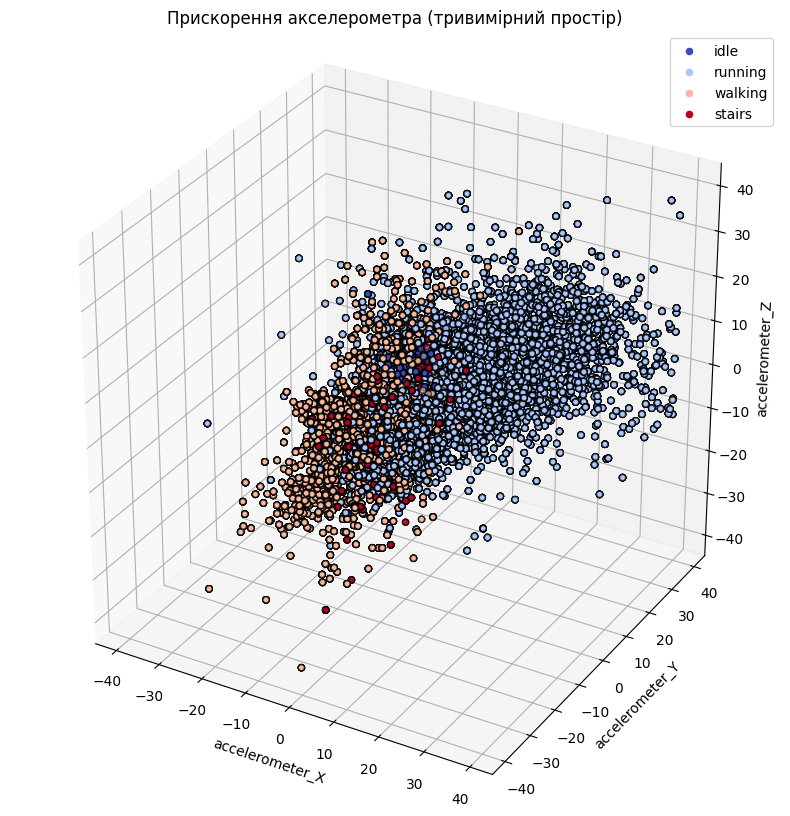

In [16]:
key = 'f0s0'
plot_3d(df_set[key])

In [19]:
def plot_3d(df_t, class_list):
    xx = df_t.iloc[:, 0]
    yy = df_t.iloc[:, 1]
    zz = df_t.iloc[:, 2]
    cc = df_t.iloc[:, 3]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    sc = ax.scatter(xx, yy, zz, c=cc, cmap='coolwarm', edgecolors='k')
    unique_categories = np.unique(cc)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_categories)))

    for i, c in enumerate(unique_categories):
        ax.scatter([], [], [], color=colors[i], label=f'{class_list[int(c)]}')

    ax.set_xlabel(df_t.columns[0])
    ax.set_ylabel(df_t.columns[1])
    ax.set_zlabel(df_t.columns[2])
    ax.set_title('3D Scatter Plot')
    ax.set_box_aspect([1, 1, 1])
    ax.legend()
    plt.show()


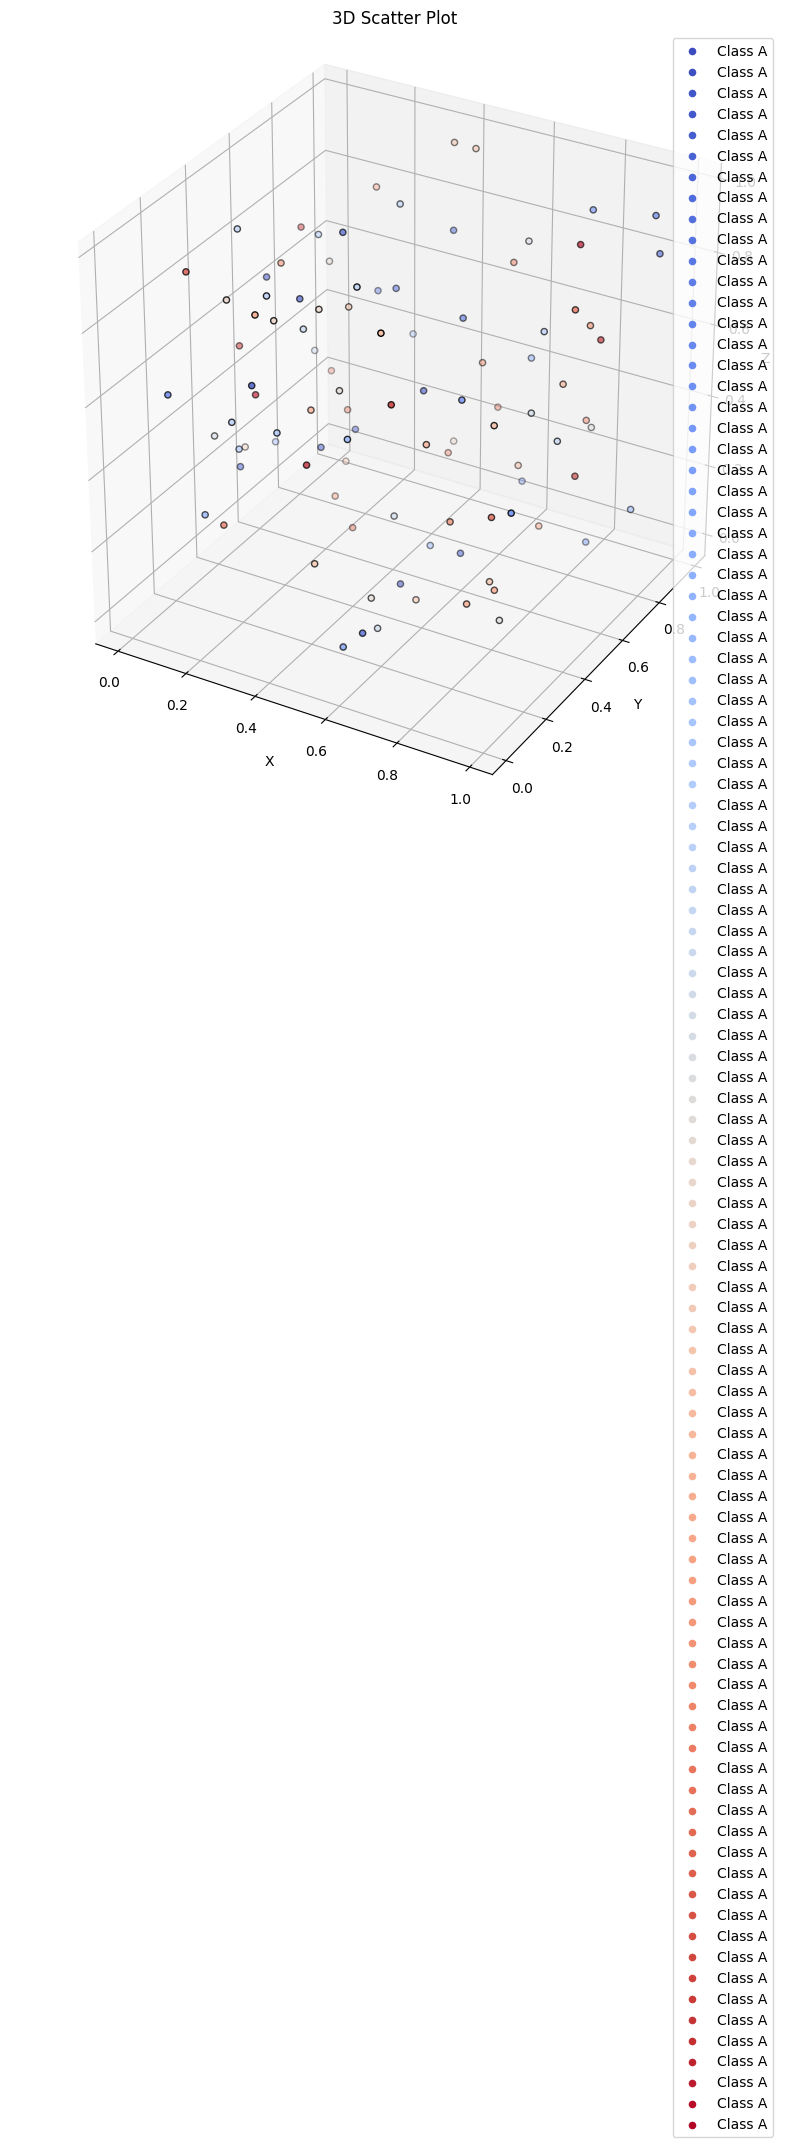

In [20]:
np.random.seed(42)
data = np.random.rand(100, 3)
df_random = pd.DataFrame(data, columns=['X', 'Y', 'Z'])

df_random['Color'] = np.random.rand(100)

class_list = ["Class A", "Class B", "Class C"]

plot_3d(df_random, class_list)